# Anomalous user detection using numeric features

We start with the simplest approach, namely characterizing each user's behavior within a given time window through numeric features.
The resulting feature vectors can then be fed to standard anomaly detection algorithms to identify outliers.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from scipy.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from utils import evaluate_algo, evaluate_algo_events, plot_examples

In [2]:
seed = 123 # No one likes randomness
np.random.seed(seed)

The dataset is generated as follows.
First of all, authentication events are aggregated by destination user.
Then, for each user, the corresponding events are aggregated by day, yielding 13 event sets -- 8 for the training period and 5 for the testing period.
Note that all users are not active on each day, thus the set of events involving a given user on a specific day might be empty.
Each non-empty event set is finally abstracted into a fixed-size vector by extracting the following features:

- Number of logon events (`num_events`)
- Number of computers to which the user has logged on locally (`num_local`)
- Number of computers from and to which the user has logged on remotely (`num_src` and `num_dst`, respectively)
- Number of computers to which the user has logged on using the following authentication packages: Kerberos or Negotiate (`num_kerberos`), NTLM (`num_ntlm`) and Microsoft Authentication Package v1.0 (`num_msv_1_0`)
- Number of computers to which the user has logged on with the following logon types: Network (`num_network`), Remote Interactive (`num_rdp`) and any other type (`num_other`).

The meaning of the first four features is rather straightforward.
As for the others, the main thing you need to know is that different logon types and authentication packages (APs) correspond to different kinds of activity, thus user credentials being used to authenticate with unusual logon types and APs can be considered suspicious.
For more information on logon types and APs, see for instance [here](https://www.ultimatewindowssecurity.com/securitylog/book/page.aspx?spid=chapter3) and [there](https://www.ultimatewindowssecurity.com/securitylog/book/page.aspx?spid=chapter4).

In [3]:
dir_path = os.path.join('data', 'user_features')

In [4]:
features = pd.read_csv(                     # Read feature vectors
    os.path.join(dir_path, 'features.csv'),
    index_col=0)
idents = pd.read_csv(                       # Read instance identifiers (user name + day)
    os.path.join(dir_path, 'idents.csv'),
    index_col=0)
labels = pd.read_csv(                       # Read instance labels (0 for benign, 1 for malicious)
    os.path.join(dir_path, 'labels.csv'),
    index_col=0)

X = np.array(features).astype(np.float64)
y = np.array(labels)[:,0]

idents.insert(
    1, 'username',
    idents['ident'].apply(lambda x: x.split('_')[0])
)
idents.insert(
    2, 'day',
    idents['ident'].apply(lambda x: int(x.split('_')[1]))
)

In [5]:
# Train-test split: first 8 days for training, next 5 days for testing
n_train = idents[idents['day']<8].shape[0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_train, shuffle=False)

First of all, let's take a look at the data.
We first study the marginal distribution of each feature.

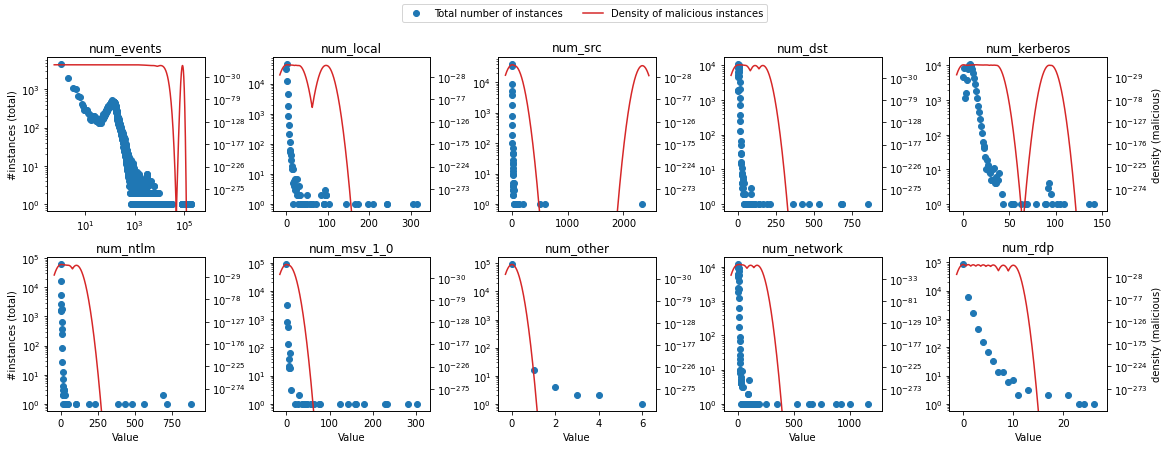

In [9]:
fig = plt.figure()
axes = fig.subplots(2, 5).flatten()
logscale = (0,)
X_mal = X[y==1]
for i, col in enumerate(features):
    lines = []
    val, cnt = np.unique(X[:,i], return_counts=True)
    lines.append(axes[i].scatter(val, cnt))
    axes[i].set_title(col)
    if i in logscale:
        axes[i].loglog()
    else:
        axes[i].set_yscale('log')
    if i % 5 == 0:
        axes[i].set_ylabel('#instances (total)')
    if i//5 == 1:
        axes[i].set_xlabel('Value')
    ax = axes[i].twinx()
    kde = KernelDensity(
        bandwidth=(X[:,i].max()-X[:,i].min())/200
        ).fit(X_mal[:,i,np.newaxis])
    xs = np.linspace(*ax.get_xlim(), 1000)
    lines.append(
        ax.plot(xs, np.exp(kde.score_samples(xs[:,np.newaxis])), color='tab:red')[0]
    )
    ax.set_yscale('log')
    if i % 5 == 4:
        ax.set_ylabel('density (malicious)')
fig.set_size_inches(19, 6.5)
fig.legend(
    handles=lines,
    labels=['Total number of instances', 'Density of malicious instances'],
    loc='upper center',
    ncol=2
)
plt.subplots_adjust(hspace=.3, wspace=.43)
plt.show()

What do we see?
First of all, most features have a long-tailed distribution, which is an expected consequence of the diversity of user accounts.
Keep in mind that what we call a user here is not necessarily a human being: some user accounts are actually only used to manage the rights and privileges of services running inside the network (and also allow these services to communicate securely with each other).
These accounts may thus be involved in a large number of authentication events.
Besides, admin accounts can typically be expected to log on to more hosts than regular user accounts.
This is well reflected by the marginal distributions shown above.

Focusing on the difference between benign and malicious instances, the latter tend to exhibit larger feature values.
One possible explanation is that malicious behavior is additive, so to speak: compromised accounts start authenticating to additional hosts besides the usual ones, and the same goes for the total number of events.
A more pessimistic interpretation, however, is that accounts usually logging on to many hosts are simply more likely to be compromised: the corresponding credentials can be found more easily on previously compromised hosts, and their ability to access many resources makes them interesting targets.
In other words, accounts may not authenticate to many hosts because they are compromised, but rather get compromised because they authenticate to many hosts.
From a detection perspective, this obviously matters: if the second explanation is the right one, then outlier detection on the instances we defined should raise many false positives.

We now turn to the dependence structure of the features.

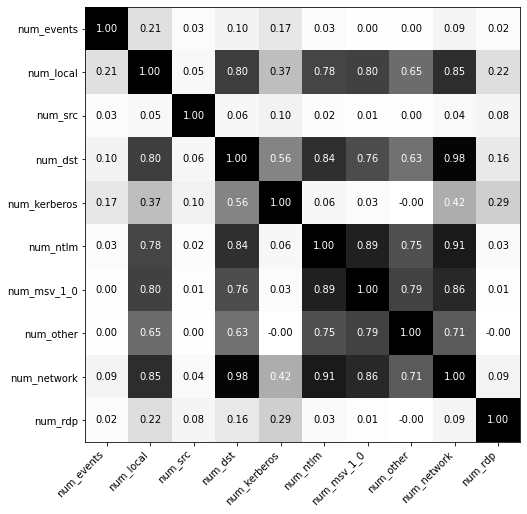

In [24]:
n, d = X.shape
corr = np.ones((d, d))
for i in range(d):
    for j in range(i):
        r, p = pearsonr(X[:,i], X[:,j])
        corr[i, j] = r
        corr[j, i] = r
fig = plt.figure()
plt.imshow(corr, cmap='Greys')
ax = plt.gca()
ax.set_xticks(np.arange(d))
ax.set_xticklabels(features.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(d))
ax.set_yticklabels(features.columns)
colors = ['black', 'white']
for i in range(d):
    for j in range(d):
        ax.text(i, j, '{0:.2f}'.format(corr[i,j]),
            ha='center', va='center',
            color=colors[int(corr[i,j]>.4)])
fig.set_size_inches(8.2, 8)
plt.show()

A lot of strong correlations can be observed, which is not much of a surprise: for instance, a user authenticating to many hosts overall can also be expected to log on to many hosts for at least one logon type or AP.
From a detection perspective, it can thus be interesting to look for unusual correlations between the features of a given instance.

Finally, let's see if dimensionality reduction and visualization provide any interesting insight.

In [6]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

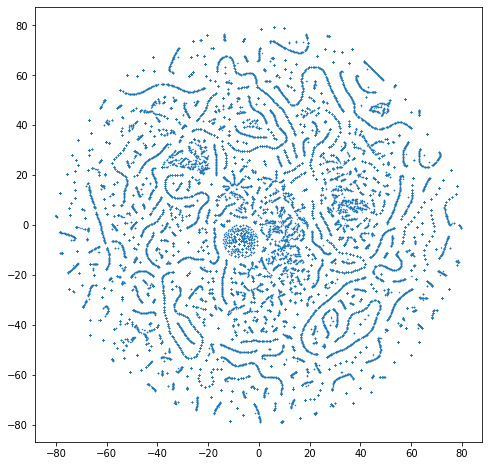

In [16]:
tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_jobs=-1)
X_emb = tsne.fit_transform(scaler.transform(X_train_scaled))

fig = plt.figure()
plt.scatter(X_emb[:,0], X_emb[:,1], s=.1)
fig.set_size_inches(8, 8)
plt.show()

Not much to say, except that there does not seem to be a clear multimodal structure.
Note that there are many outliers, which is not good news for us: it suggests that anomaly detection algorithms may return many things besides malicious instances &mdash; in other words, precision can be expected to be low.

Well, let's get to it!
We've got data and some labelled malicious instances, so let's see what simple anomaly detection algorithms can do for us.
We start with a basic dimensionality reduction approach, which has been applied a few times for intrusion detection in event logs [LBGC15, HTL17].
The idea is to use Principal Component Analysis (PCA) to learn a low-dimensional representation of the data using the training set.
The reconstruction error on vectors from the test set can then be used as an anomaly score.
There is one hyperparameter to set, namely the dimension of the reduced space.
We can try to guess a sensible value by looking at the amount of variance explained by the first $k$ principal components, for various values of $k$.

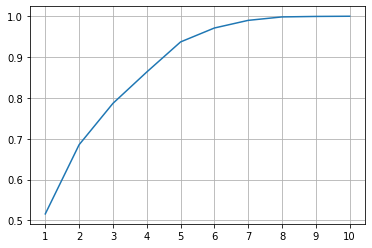

In [10]:
pca = PCA(random_state=seed).fit(X_train_scaled)
plt.plot(
    np.arange(1, X.shape[1]+1),
    np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(1, X.shape[1]+1))
plt.grid()
plt.show()

Well, looks like 2 or 3 components do the job.
That's actually an expected consequence of the strong correlations between some of the features we extracted: the "true" dimension of the data is rather low.
We can thus set $k$ to a small value.

Now let's detect stuff!
The anomaly detection method we use returns positive scores, with larger scores corresponding to anomalies.
A detection threshold can then be set to turn these scores into binary predictions.
We evaluate detection performance using two standard metrics: the Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves. The former plots the detection rate (i.e., the proportion of malicious instances that are detected) as a function of the false positive rate (i.e., the proportion of benign instances that are incorrectly flagged malicious) for decreasing detection thresholds. The latter plots precision (i.e., the proportion of true positives among all flagged instances) as a function of the detection rate (also called recall), also for decreasing detection thresholds. Basically, we want both curves to be as high as possible.

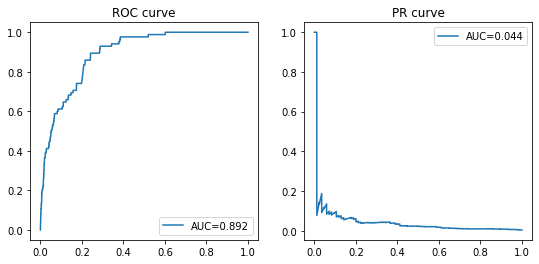

In [11]:
n_comp = 2
y_pred = np.linalg.norm(
    pca.transform(X_test_scaled)[:,n_comp:],
    axis=1)

evaluate_algo(y_test, y_pred)

That's not entirely awful, but not great either.
Note that the PR curve looks much worse than the ROC curve, which is typical in imbalanced settings: since there are many more benign instances than malicious ones, even a small false positive rate (FPR) and a high detection rate can lead to a low precision.
More specifically, there are 85 malicious instances and more than 35,000 benign ones in the test set.
Therefore, even with a 1% FPR, we already have more false positives than malicious instances.

Let's take a closer look at some correctly and incorrectly classified instances.

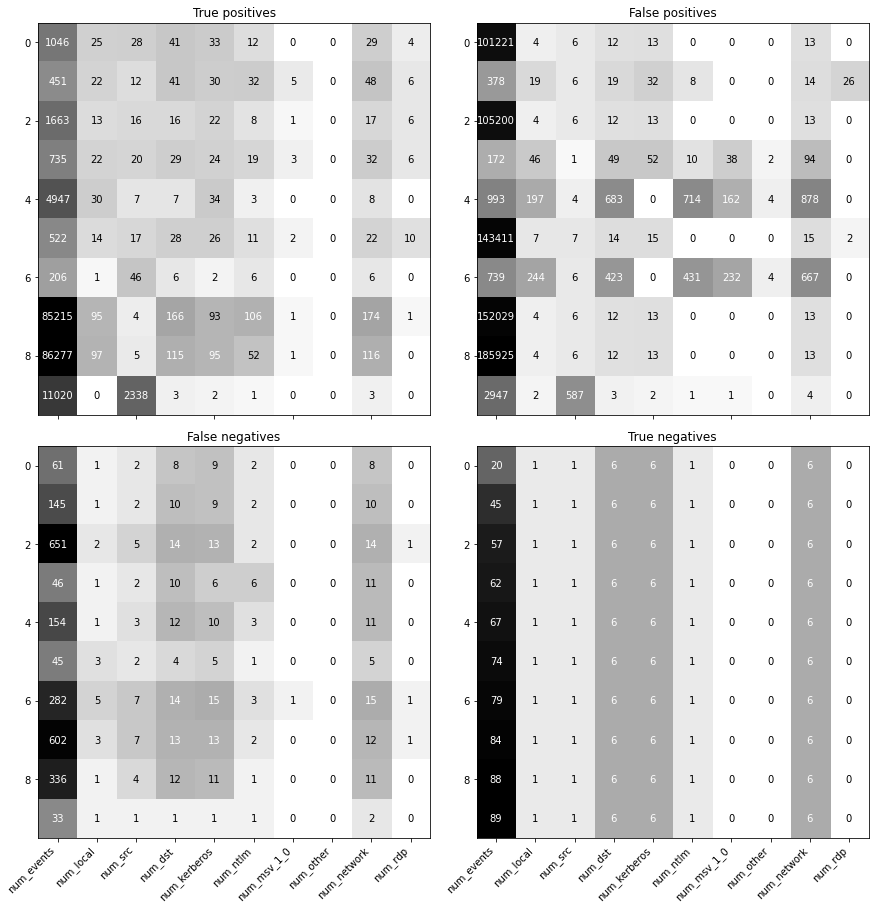

In [12]:
plot_examples(X_test, y_test, y_pred, features.columns)

A global trend seems to appear: instances with large feature values get classified as malicious, while small values are considered benign.
That could be expected given the fact that the considered features are counts: since they are necessarily positive, the only way an instance can fall far away from the others is through large values.
Moreover, our exploratory analysis highlighted the long-tailed nature of the marginal distributions.
It thus seems reasonable to think that attenuating this unbalancedness may lead to a less trivial definition of outliers &mdash; and maybe better detection performance.
So let's try to rescale unbalanced features by squashing them through a log function.

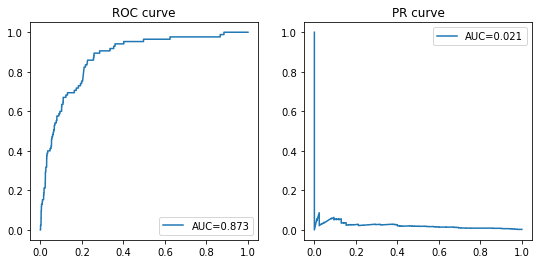

In [13]:
X_train_log = np.array(X_train)
X_test_log = np.array(X_test)
for col in (0, 1, 2, 3, 4, 5, 6, 8):
    X_train_log[:,col] = np.log(1+X_train_log[:,col])
    X_test_log[:,col] = np.log(1+X_test_log[:,col])
scaler_log = StandardScaler().fit(X_train_log)
X_train_log_scaled = scaler_log.transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

pca = PCA(random_state=seed).fit(X_train_log_scaled)
n_comp = 2
y_pred = np.linalg.norm(
    pca.transform(X_test_log_scaled)[:,n_comp:],
    axis=1)

evaluate_algo(y_test, y_pred)

Looks like that didn't help: looking for very large feature values actually seems to be the best way to find malicious instances.
Let's try to do that with another algorithm, namely Isolation Forest [LTZ08].
If you don't know anything about Isolation Forest, the main idea is to iteratively partition the dataset through random splits: at each iteration, a feature is randomly selected, and the remaining instances are split into two sets according to their respective values along that feature.
More specifically, a random threshold is sampled, and the subset into which each instance is put depends on whether this instance's value along the selected feature is above or below the threshold.
The rationale behind this algorithm is that outliers end up alone in their own subset after a few random splits, whereas inliers are harder to separate from each other.
Since this approach does not need to learn normal behavior using a clean training dataset, we can directly apply it to the test set.

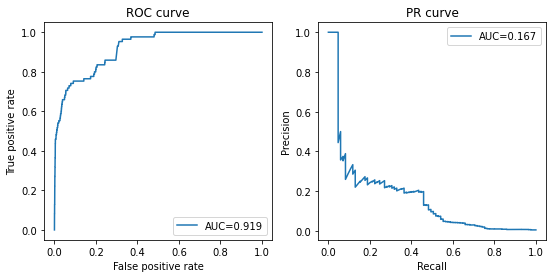

In [7]:
iforest = IsolationForest(random_state=seed).fit(X_test_scaled)
y_pred = 1-iforest.score_samples(X_test_scaled)                  # Complement to 1 for consistency with our labels
evaluate_algo(y_test, y_pred)

Better, right? Let's take a closer look at how it works by computing the importance of each feature. To that end, we use SHAP values [LL17]. For each instance, SHAP estimates the impact of each feature on the prediction returned by the model for this instance; this impact is measured by computing the average variation of the model's prediction obtained by including the considered feature.

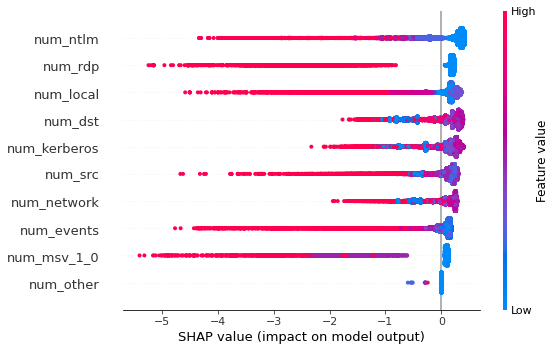

In [28]:
explainer = shap.TreeExplainer(
    iforest,
    feature_names=features.columns)
shap_val = explainer(X_test_scaled)
shap.plots.beeswarm(shap_val)

This plot is computed with the original model, so negative SHAP values mean that the corresponding feature makes the instance more anomalous.
The results are globally consistent with our previous observations: large feature values lead to anomalies.
There are, however, some discrepancies: in particular, for `num_src`, `num_dst`, `num_kerberos` and `num_network`, the map between feature values and SHAP values seems to look more like a bell-shaped curve, with both small and large feature values having a negative impact.

Another aspect worth investigating is the performance of the model *at the event granularity*.
Indeed, the instances we defined (user-days) are not all equivalent in terms of analyst workload: investigating the behavior of a user on a given day basically means looking at the underlying events and trying to make sense of them, so the amount of work required to analyze an anomalous instance depends on the number of events it summarizes.
It is thus interesting to compute our performance metrics for events rather than user-days.
To that end, we give each event the same anomaly score as the corresponding instance.

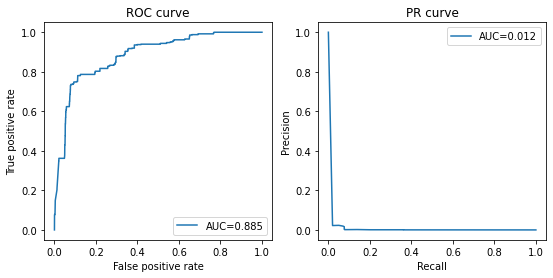

In [8]:
event_counts = pd.read_csv(
    os.path.join(dir_path, 'counts.csv'),
    index_col=0)

counts_test = event_counts[idents['day']>=8].to_numpy()

evaluate_algo_events(y_pred, counts_test[:,0], counts_test[:,1])

That's clearly not as good.
It's also understandable: user-days are here deemed malicious if they include at least one red team event, which implies that malicious user-days can actually contain a vast majority of benign events.
To get a more accurate picture, let's look at the actual ratio of red team events for malicious user-days from the test set.

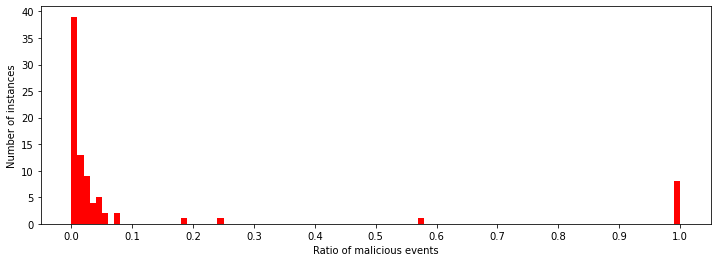

In [26]:
malicious_ratios = event_counts[(idents['day']>=8)&(event_counts['num_malicious']>0)].apply(
    lambda x: x['num_malicious']/x['num_total'],
    axis=1)
fig = plt.figure()
plt.hist(malicious_ratios, bins=100, color='red')
plt.xticks(.1*np.arange(11))
plt.xlabel('Ratio of malicious events')
plt.ylabel('Number of instances')
fig.set_size_inches(12, 4)
plt.show()

As expected, most malicious instances actually contain a low proportion of red team events (less than 1% for roughly half of them).
This is a fundamental limitation of the user-centric point of view: aggregating events by user-day often fails to isolate malicious activity, which has two negative consequences.
First, as stated above, it makes it harder to investigate anomalous instances.
Secondly, it casts doubt upon the relevance of the whole anomaly detection approach: if malicious instances actually contain a tiny proportion of red team events, it seems questionable to assume that the presence of these events makes the whole instance statistically anomalous.

Let's put these concerns aside for now and study one last anomaly detection approach.
You may have noticed that so far, we haven't at all considered the evolution of a user's behavior over time.
One could argue that this is a mistake: intuitively, anomalous user-days should be defined as being inconsistent with past behavior of the corresponding user.
However, the limited amount of available data for each user prevents us from learning one separate model per user.
An interesting alternative was proposed by Eldardiry et al. [EBL$^+$13]: we first learn a Gaussian mixture model on the training set, then study the sequence of cluster assignments obtained for each user for successive days. This sequence can be modelled as a Markov chain, and anomalous transitions should correspond to unexpected changes in a user's behavior.
Let's see how this performs here.

First of all, we build the Gaussian mixture model, which implies choosing a sensible number of clusters.
Since Gaussian mixtures are well-defined probabilistic models, we can use the Bayesian Information Criterion (BIC).
The BIC assesses the quality of a model through its likelihood, penalized by its number of parameters.
In the implementation we use, low values mean good models.

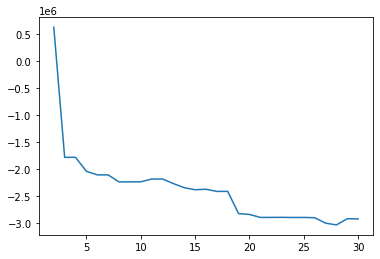

In [18]:
bic = [GaussianMixture(n_components=k, random_state=seed
    ).fit(X_train_scaled
    ).bic(X_train_scaled) for k in range(2, 31)]
plt.plot(np.arange(2, 31), bic)
plt.show()

Looks like around 20 clusters is good enough.
Next, we build the sequence of cluster assignments for each user.
Note that we need to take into account users that are not observed at all on a given day; we add a pseudo-cluster to represent them.

In [9]:
# Fetch the sequence of feature vectors for each user
user_idx = pd.DataFrame(idents.groupby('username').apply(
    lambda x: np.array(
        list(x.sort_values(by=['day']).index) + [-1 for i in range(13) if i not in set(x['day'])]
        )[np.argsort(list(x['day']) + sorted(list(set(range(13)).difference(set(x['day'])))))]
    )) # -1 means that the user does not appear on the considered day
# Fetch user labels: 1 if the user appears in at least one malicious event in the test set, 0 otherwise
tmp_labels = np.concatenate([labels['label'], [0]])
user_idx.insert(
    1, 'label',
    user_idx[0].apply(
    lambda x: tmp_labels[x[8:]].max()))

In [10]:
k = 20
gmm = GaussianMixture(n_components=k, random_state=seed)
gmm.fit(X_train_scaled)
C = np.concatenate([
    gmm.predict(X_train_scaled), gmm.predict(X_test_scaled)
])

# Fetch the sequence of cluster assignments for each user
C = np.concatenate([C, [C.max()+1]]) # Add pseudo-cluster for unobserved users
user_clusters = np.stack([C[x] for x in user_idx[0]])

We want to model this sequence using a shared Markov chain model for all users.
To that end, we extract all cluster assignment transitions happening during the first 8 days and fit a transition matrix $P$ to these transitions (where $P_{ij}$ is the probability of a user belonging to cluster $j$ on day $t+1$ given that they belong to cluster $i$ on day $t$).

In [11]:
c_train = user_clusters[:,:8]
P = np.ones((k+1, k+1)) # Ones to avoid null transition probabilities (can be seen as a Dirichlet conjugate prior)
idx, cnt = np.unique(
    ['{0}_{1}'.format(c_train[i,j], c_train[i,j+1])
         for i in range(c_train.shape[0]) for j in range(c_train.shape[1]-1)],
    return_counts=True
)
for i, c in zip(idx, cnt):
    j, l = i.split('_')
    P[int(j), int(l)] += c
P /= P.sum(1)[:,np.newaxis]

Now let's see what this matrix looks like! Remember that the $i$-th row contains transition probabilities from the $i$-th cluster to all other clusters, and that the last cluster corresponds to inactive users.

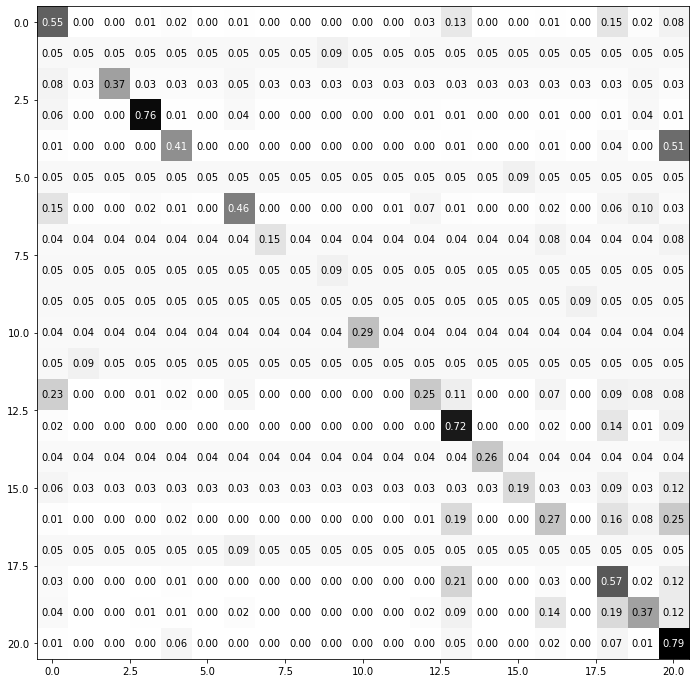

In [21]:
fig = plt.figure()
plt.imshow(P, cmap='Greys')
ax = plt.gca()
colors = ['black', 'white']
for i in range(k+1):
    for j in range(k+1):
        ax.text(i, j, '{0:.2f}'.format(P[j,i]),
            ha='center', va='center',
            color=colors[int(P[j,i]>.4)])
fig.set_size_inches(12, 12)
plt.show()

Diagonal coefficients are rather large, indicating that several clusters are somewhat "stable".
Note that the inactive cluster has the largest incoming probabilities.

Anomaly detection then works as follows: for each user, we fetch the 5 cluster transitions corresponding to the 5 days of the test set.
The anomaly score of the user can then be defined as the negative logarithm of the joint probability of these transitions: letting $C_0,\ldots,C_5$ denote the successive cluster assignments, the anomaly score is $y=-\log\left(\prod_{i=1}^5P_{C_{i-1}C_i}\right)=-\sum_{i=1}^5\log{P}_{C_{i-1}C_i}$.

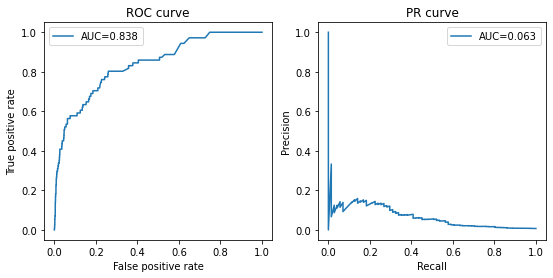

In [12]:
c_test = user_clusters[:,7:]
y_pred = -np.log(
    np.stack(
        [P[c_test[:,j], c_test[:,j+1]] for j in range(c_test.shape[1]-1)],
        axis=1
    )
).sum(1)
evaluate_algo(user_idx['label'], y_pred)

Still not great, apparently.
Note that instances are now users rather than user-days, so the results displayed above cannot be directly compared with previous ones.
Let's look at detection performance at the event granularity.

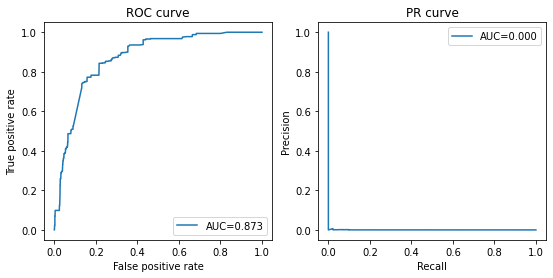

In [22]:
cnt_tot = np.concatenate([event_counts['num_total'], [0]])
cnt_mal = np.concatenate([event_counts['num_malicious'], [0]])
user_idx.insert(
    user_idx.shape[1], 'num_total',
    user_idx[0].apply(
    lambda x: cnt_tot[x[8:]].sum()))
user_idx.insert(
    user_idx.shape[1], 'num_malicious',
    user_idx[0].apply(
    lambda x: cnt_mal[x[8:]].sum()))

evaluate_algo_events(
    y_pred,
    user_idx['num_total'].to_numpy(),
    user_idx['num_malicious'].to_numpy())

We still get inferior performance with respect to the naive (time-insensitive) approach.
This suggests that the temporal aspect is actually not that important, and we will keep exploring other facets of the data in the next notebooks.

### Further reading

Describing each user's behavior on a given time window through handcrafted features is a rather intuitive approach to event log analysis.
As a consequence, many implementations of this approach can be found in the literature.
An interesting abstract description was proposed by Memory et al.&nbsp;[MGS13].
This description relies on two key notions:

* The _extent_ is the instance we wish to classify as benign or anomalous.
  It is defined as the intersection of an entity or set of entities (_entity extent_) and a time window (_temporal extent_).
  In this notebook, the entity extent is one user and the temporal extent is one day.
* The _baseline_ is the reference we use for comparison.
  It can consist of past activity of the same entity extent (_longitudinal baseline_), of activity of other entity extents in the same temporal extent (_cross-sectional baseline_) or a combination of the former (_simultaneous baseline_).
  In this notebook, we use simultaneous baselines.
  
Various kinds of features and algorithms have been proposed for anomalous user behavior detection.
In particular, beyond the simple anomaly detection algorithms used in this notebook, some more sophisticated, deep learning-based methods have been used as well.
An interesting example is the RNN-based approach of Tuor et al.&nbsp;[TKH$^+$17], which models the sequence of feature vectors observed for each user using a shared LSTM network.
More indirect methods exist as well; for instance, Garchery and Granitzer&nbsp;[GG19] proposed to predict the identity of a user given their feature vector and look for prediction errors in order to detect stolen credentials.

Finally, a natural alternative to user behavior monitoring is its host-centric counterpart.
Similar detection methodologies (event aggregation, feature extraction, anomaly detection) have been applied in this context, see for instance [YOO$^+$13,&nbsp;GBC15,&nbsp;BNFS17].
Among the interesting innovations which have been proposed for host behavior monitoring, the active anomaly detection approach of Siddiqui et al.&nbsp;[SSS$^+$19] can be mentioned.
It allows the analyst to provide feedback about the model's predictions, allowing continuous and more efficient training (and hopefully reducing the false positive rate).

### References

[BNFS17] Atul Bohara, Mohammad Noureddine, Ahmed Fawaz, and William Sanders. An Unsupervised Multi-Detector Approach for Identifying Malicious Lateral Movement. In _SRDS_, 2017.

[EBL$^+$13] Hoda Eldardiry, Evgeniy Bart, Juan Liu, John Hanley, Bob Price, and Oliver Brdiczka. Multi-Domain Information Fusion for Insider Threat Detection. In _S&P Workshops_, 2013.

[GBC15] Daniel Gonçalves, João Bota, and Miguel Correia. Big Data Analytics for Detecting Host Misbehavior in Large Logs. In _Trustcom_, 2015.

[GG19] Mathieu Garchery and Michael Granitzer. Identifying and Clustering Users for Unsupervised Intrusion Detection in Corporate Audit Sessions. In _ICCC_, 2019.

[HTL17] Qiaona Hu, Baoming Tang, and Derek Lin. Anomalous User Activity Detection in Enterprise Multi-Source Logs. In _ICDM Workshops_, 2017.

[LBGC15] Philip Legg, Oliver Buckley, Michael Goldsmith, and Sadie Creese. Automated Insider Threat Detection System Using User and Role-Based Profile Assessment. In _IEEE Systems Journal_, 11(2), 2015.

[LL17] Scott Lundberg and Su-In Lee. A Unified Approach to Interpreting Model Predictions. In _NeurIPS_, 2017.

[LTZ08] Fei Tony Liu, Kai Ming Ting, and Zhi-Hua Zhou. Isolation Forest. In _ICDM_, 2008.

[MGS13] Alex Memory, Henry Goldberg, and Ted Senator. Context-Aware Insider Threat Detection. In _AAAI Workshops_, 2013.

[SSS$^+$19] Md Amran Siddiqui, Jack Stokes, Christian Seifert, Evan Argyle, Robert McCann, Joshua Neil, and Justin Carroll. Detecting Cyber Attacks Using Anomaly Detection with Explanations and Expert Feedback. In _ICASSP_, 2019.

[TKH$^+$17] Aaron Tuor, Samuel Kaplan, Brian Hutchinson, Nicole Nichols, and Sean Robinson. Deep Learning for Unsupervised Insider Threat Detection in Structured Cybersecurity Data Streams. In _AAAI Workshops_, 2017.

[YOO$^+$13] Ting-Fang Yen, Alina Oprea, Kaan Onarlioglu, Todd Leetham, William Robertson, Ari Juels, and Engin Kirda. Beehive: Large-Scale Log Analysis for Detecting Suspicious Activity in Enterprise Networks. In _ACSAC_, 2013.